# Laboratorio 5 - Scalet dot product attention

Nombre: Polo Orellana Brayan Simon
Github: 

En este laboratorio se aplico el `Scaled Dot Prouduct Attention` para reconocimiento y clasificación de deschos solidos con 5 clases de objetos.

## 1. Importacion de librerias necesarias

In [ ]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import numpy as np
import math
import sys
import math

## 2.- Definicion de Hiperparametros

In [7]:
patch_size = (16, 16)      # Tamaño de cada patch (afecta n_embd)
img_size = (224, 224)      # Resolución de entrada (afecta seq_len)
batch_size = 16            # Tamaño del batch (afecta memoria)

n_embd = 3 * 16 * 16       # 768 - Dimensiones del embedding por patch
seq_len = 14 * 14          # 196 - Número total de patches
num_classes = 5            # Número de clases de tu dataset
dropout = 0.3              # Regularización para evitar overfitting

learning_rate = 1e-4       # Tasa de aprendizaje
weight_decay = 1e-4        # Regularización L2
optimizer = "AdamW"        # Optimizador (Adam, AdamW, SGD)

max_epochs = 20            # Épocas máximas
precision = 32             # Precisión (16 para GPU, 32 para CPU)
accumulate_grad_batches = 1 # Acumulación de gradientes

## 3.- Creacion de AttnDataset

Para esta parte del dataset se uso la carga floja que consta que las imágenes se cargan solo cuando se necesitan (__getitem__). Esto me ayudo a no poner todas las imagenes en un array de numpy y cargarlos todos a la memoria.

Lo que se hace es guardar todas las rutas de las imagenes y sus labes, ambos retornarlos en listas distintas.

In [8]:
class LazyAttnDataset(Dataset):
    def __init__(self, data_dir, patch_size=(16, 16), img_size=(224, 224)):
        self.files, self.labels = [], []
        self.patch_size = patch_size
        self.img_size = img_size
        
        for label, classname in enumerate(sorted(os.listdir(data_dir))):
            class_dir = os.path.join(data_dir, classname)
            if not os.path.isdir(class_dir):
                continue
            for fname in os.listdir(class_dir):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.files.append(os.path.join(class_dir, fname))
                    self.labels.append(label)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        img = Image.open(self.files[ix]).convert("RGB")
        img = img.resize(self.img_size)
        img = torch.tensor(np.array(img)).float().permute(2, 0, 1) / 255
        
        C, H, W = img.shape
        hh, ww = self.patch_size
        
        # Verificar que las dimensiones sean divisibles
        assert H % hh == 0, f"Height {H} not divisible by patch height {hh}"
        assert W % ww == 0, f"Width {W} not divisible by patch width {ww}"
        
        patches = img.unfold(1, hh, hh).unfold(2, ww, ww)
        patches = patches.permute(1, 2, 0, 3, 4).contiguous()
        patches = patches.view(-1, C * hh * ww)
        label = torch.tensor(self.labels[ix]).long()
        
        return patches, label


In [9]:
from torch.utils.data import DataLoader

train_dataset = LazyAttnDataset(r"D:\Ciencias\Dataset Residuos solidos\data\train", patch_size=patch_size, img_size=img_size)
val_dataset = LazyAttnDataset(r"D:\Ciencias\Dataset Residuos solidos\data\val", patch_size=patch_size, img_size=img_size)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [10]:
# Tomar un batch
imgs, labels = next(iter(train_loader))  # imgs.shape = [batch_size, C, H, W]

print("Batch shape:", imgs.shape)  # e.g., [32, 3, 224, 224]

# Aplanar cada imagen del batch
imgs_flat = imgs.view(imgs.size(0), -1)
print("Batch aplanado:", imgs_flat.shape)  # e.g., [32, 150528]

# Mostrar la primera imagen
print("Primera imagen (tensor):")
print(imgs[0])  # shape [3, 224, 224]

print("#"*30)

# Primera imagen aplanada
print("Primera imagen aplanada:")
print(imgs_flat[0])  # shape [150528]


Batch shape: torch.Size([16, 196, 768])
Batch aplanado: torch.Size([16, 150528])
Primera imagen (tensor):
tensor([[0.4745, 0.4902, 0.4980,  ..., 0.7216, 0.7373, 0.7490],
        [0.7647, 0.7804, 0.7725,  ..., 0.8314, 0.8353, 0.8392],
        [0.2980, 0.2980, 0.2941,  ..., 0.3882, 0.3529, 0.3333],
        ...,
        [0.1569, 0.1647, 0.1686,  ..., 0.1137, 0.1137, 0.1059],
        [0.1765, 0.1765, 0.1765,  ..., 0.1098, 0.1176, 0.1216],
        [0.1882, 0.1843, 0.1843,  ..., 0.1294, 0.1412, 0.1451]])
##############################
Primera imagen aplanada:
tensor([0.4745, 0.4902, 0.4980,  ..., 0.1294, 0.1412, 0.1451])


## 4.- Creacion del Modulo

Para esta clase heradada de **pl.LightningDataModule**, nos ayuda a organizar y automatizar la carga de datos para entrenamiento y validación en PyTorch Lightning.

In [11]:
class DesechosDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=16, patch_size=(16, 16), img_size=(224, 224)):
        super().__init__()
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.img_size = img_size

    def setup(self, stage=None):
        self.train_ds = LazyAttnDataset(
            r"D:\Ciencias\Dataset Residuos solidos\data\train",
            patch_size=self.patch_size,
            img_size=self.img_size
        )
        self.val_ds = LazyAttnDataset(
            r"D:\Ciencias\Dataset Residuos solidos\data\val",
            patch_size=self.patch_size,
            img_size=self.img_size
        )

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size)

In [12]:
imgsprueba = torch.rand(3,224,224)
print(imgsprueba.shape)

torch.Size([3, 224, 224])


In [13]:
#Creamos una imagen de prueba random
imgsprueba = torch.rand(3,224,224)  # RGB
C, H, W = imgsprueba.shape

#Definimos el tamaño de los patches
hh, ww = 16, 16

#Divide la imagen en patches no superpuestos de tamaño (hh, ww)
patches = imgsprueba.unfold(1, hh, hh).unfold(2, ww, ww)  # (C, 14, 14, 16, 16)
print(patches.shape)

#Reorganiza los parches para tenerlos en la forma (14, 14, C, 16, 16)
patches = patches.permute(1, 2, 0, 3, 4).contiguous()      # (14, 14, C, 16, 16)
print(patches.shape)

#Aplana cada parche a un vector de tamaño C*hh*ww
patches_flat = patches.view(-1, C*hh*ww) # (196, 768) (n_patches, patch_size)
print(patches_flat.shape)


torch.Size([3, 14, 14, 16, 16])
torch.Size([14, 14, 3, 16, 16])
torch.Size([196, 768])


## 5.- Vizualizacion de setup y patches de la imagen

In [14]:
#creamos el datamodule
attn_dm = DesechosDataModule(batch_size=batch_size, patch_size=patch_size, img_size=img_size)

#Configuramos el datamodule usando internamente el AttnDataset
attn_dm.setup()

In [15]:
#Probamos el dataloader

imgs, labels = next(iter(attn_dm.train_dataloader())) #obtenemos un batch

#Comprobamos las dimensiones
imgs.shape, labels.shape

(torch.Size([16, 196, 768]), torch.Size([16]))

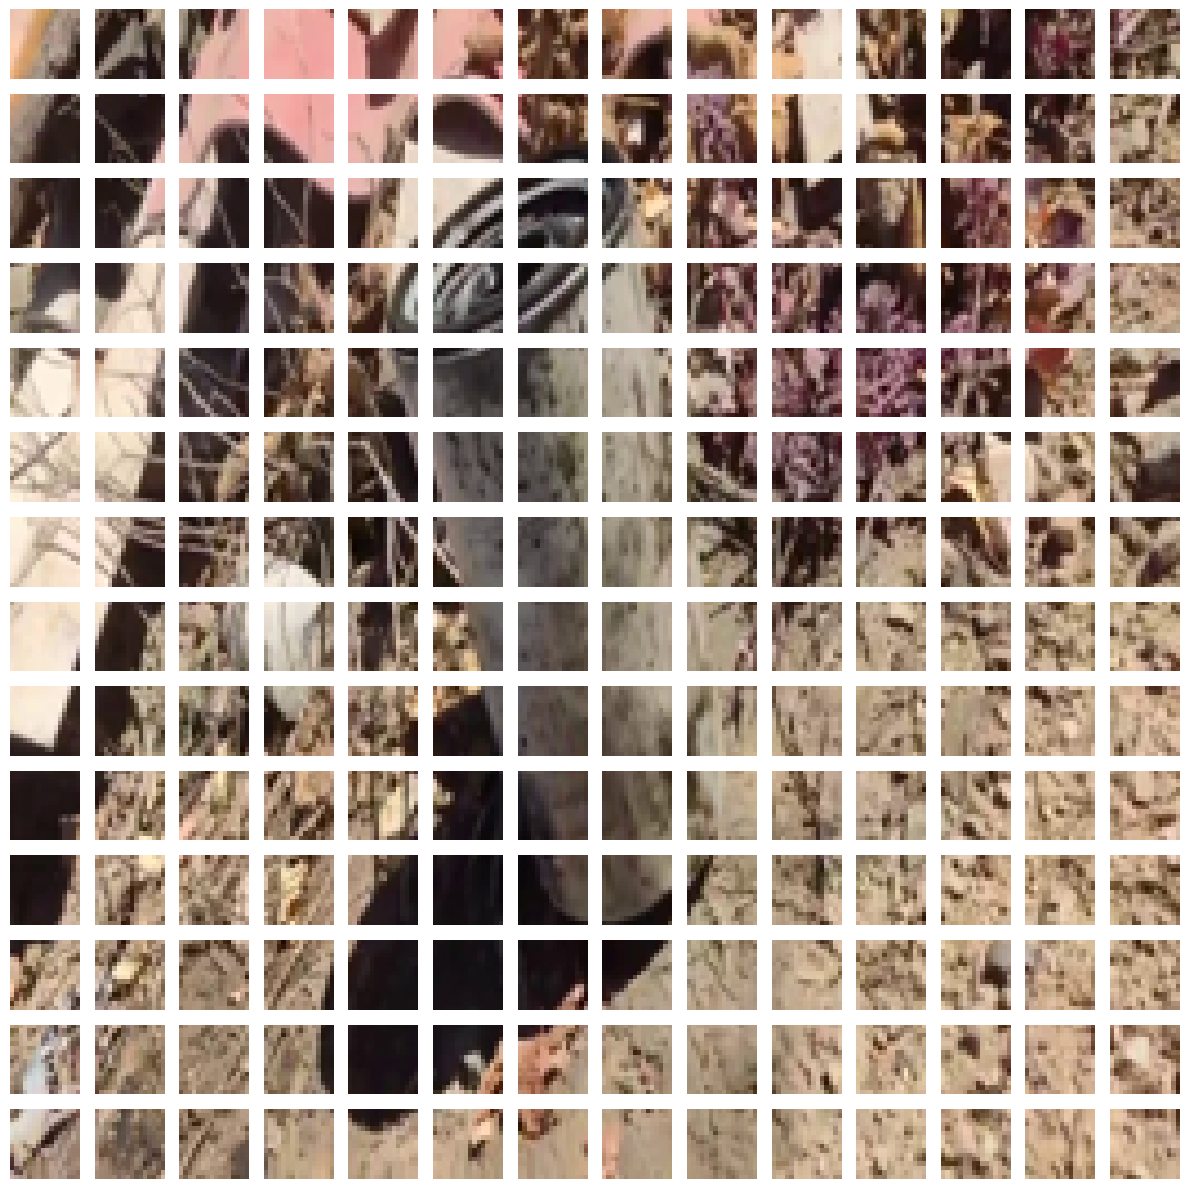

In [16]:
import matplotlib.pyplot as plt

# Tomamos un batch
patches_batch, labels = next(iter(attn_dm.train_dataloader()))  # (B, num_patches, C*hh*ww)
hh, ww = 16, 16 
C = 3

# Primer ejemplo del batch
patches = patches_batch[0]  # (196, 768)

# Grid 14x14 de todos los patches5
fig = plt.figure(figsize=(12,12))
for i in range(14):
    for j in range(14):
        idx = i*14 + j
        patch_flat = patches[idx]            # (768,)
        patch = patch_flat.view(C, hh, ww)   # (3,16,16)
        patch = patch.permute(1, 2, 0)       # (16,16,3)
        ax = plt.subplot(14, 14, idx+1)
        ax.imshow(patch.numpy())
        ax.axis('off')

plt.tight_layout()
plt.show()


## 6.- Clase ScaledDotSelfAttention

Esta clase implementa el mecanismo de **Scaled Dot Product Attention**, la cual es la base para los transformers. Tiene el objetivo de permitir que cawda patch o elemento de una secuencia "atienda" a todos los demas, aprendiendo de relaciones internas. Lo cual permite que el modelo relacione información entre todos los patches de la imagen, capturando dependencias globales.



In [ ]:
class ScaledDotSelfAttention(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        #Definimos las capas lineales para key, query y value
        self.key = nn.Linear(n_embd, n_embd)
        self.query = nn.Linear(n_embd, n_embd)
        self.value = nn.Linear(n_embd, n_embd)

    def forward(self, x):
        B, L, F = x.size()
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        
        #Calculamos la matriz de atención
        att = (q @ k.transpose(1, 2)) * (1.0 / math.sqrt(k.size(-1)))
        
        #Aplicamos softmax para obtener pesos de atención
        att = nn.functional.softmax(att, dim=-1)
        
        # Calculamos la salida ponderada por atención
        y = att @ v
        return y

## 7.- Creacion del Modelo

Este modelo es una red neuronal para clasificacion de imagenes basada en **self-attention** 

- Inicialmente recibe un batcj de imanges ya convertidas a secuencias de patches **(batch, 196, 768)**
- Aplicamos dos bloques de self-attention
- Aplicamos dos capas de Normalizacion. Esto nos ayuda a que cada patch vea a todos los demas y se enriquezca con informacion global de la imagen
- Aplana la secuencia resultante y la pasa por un MLP (red neuronal densa) para predecir la clase de la imagen.
- Usa **CrossEntropyLoss** para calcular la pérdida y reporta precisión durante entrenamiento y validación.


In [ ]:
class EnhancedAttentionModel(pl.LightningModule):
    def __init__(self, n_embd=768, seq_len=196, num_classes=5, dropout=0.3):
        super().__init__()
        self.save_hyperparameters()
        
        # Debug: mostrar dimensiones
        print(f"Model parameters - n_embd: {n_embd}, seq_len: {seq_len}")
        print(f"MLP input dimension: {n_embd * seq_len}")

        self.attn1 = ScaledDotSelfAttention(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.attn2 = ScaledDotSelfAttention(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        
        self.mlp = nn.Sequential(
            nn.Linear(n_embd * seq_len, 512),  # 768 * 196 = 150528
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )
        
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        # Primer bloque de atención
        x_attn = self.attn1(x)
        x = self.ln1(x + x_attn)
        
        # Segundo bloque de atención
        x_attn = self.attn2(x)
        x = self.ln2(x + x_attn)
        
        x = x.reshape(x.size(0), -1)  # (batch_size, n_embd * seq_len)
        return self.mlp(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)


In [20]:
C = 3  # RGB

n_embd = C * patch_size[0] * patch_size[1]  # 3 * 16 * 16 = 768
seq_len = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])  # 14 * 14 = 196

print(f"Calculated dimensions:")
print(f"n_embd: {n_embd}")
print(f"seq_len: {seq_len}")
print(f"MLP input: {n_embd * seq_len}")  # 768 * 196 = 150528

Calculated dimensions:
n_embd: 768
seq_len: 196
MLP input: 150528


## 7.- Entrenamiento del modelo

In [ ]:
attn_dm = DesechosDataModule(
    batch_size=batch_size,
    patch_size=patch_size,
    img_size=img_size
)
attn_dm.setup()

# Verificar dimensiones del dataset
train_loader = attn_dm.train_dataloader()
patches_batch, labels = next(iter(train_loader))
print(f"Batch shape: {patches_batch.shape}")  # Debería ser (16, 196, 768)

# Modelo con dimensiones correctas
model = EnhancedAttentionModel(
    n_embd=n_embd,
    seq_len=seq_len,
    num_classes=5  # Cambiado a 5 clases (no 3)
)

# Entrenamiento
trainer = pl.Trainer(
    max_epochs=max_epochs,
    precision=precision, # 16 para GPU, 32 para CPU
    enable_progress_bar=True,
    enable_model_summary=True
)

# Entrenar
trainer.fit(model, attn_dm)

Batch shape: torch.Size([16, 196, 768])
Model parameters - n_embd: 768, seq_len: 196
MLP input dimension: 150528


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | attn1     | ScaledDotSelfAttention | 1.8 M  | train
1 | ln1       | LayerNorm              | 1.5 K  | train
2 | attn2     | ScaledDotSelfAttention | 1.8 M  | train
3 | ln2       | LayerNorm              | 1.5 K  | train
4 | mlp       | Sequential             | 77.2 M | train
5 | criterion | CrossEntropyLoss       | 0      | train
-------------------------------------------------------------
80.8 M    Trainable params
0         Non-trainable params
80.8 M    Total params
323.000   Total estimated model params 

Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 199.91it/s]

d:\Programs\Python\3.12.7\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


d:\Programs\Python\3.12.7\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 2: 100%|██████████| 2501/2501 [08:01<00:00,  5.19it/s, v_num=0, train_loss=0.0638, train_acc=0.917, val_loss=0.0336, val_acc=0.988] 

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 2501/2501 [08:05<00:00,  5.15it/s, v_num=0, train_loss=0.0638, train_acc=0.917, val_loss=0.0336, val_acc=0.988]


## 8.- Resultados

- **Numero de epocas:** 3
- **train_acc:** 9.17%
- **val_acc:** 98.8%
- **train_loss:** 0.0638
- **val_loss:** 0.0336

## 9.- Analisis del modelo

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from turtle import pd  # Esto parece un error, lo quito

# Configurar estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def plot_from_dataframe(data):
    """Generar gráficas desde un DataFrame con los datos, incluyendo validation"""
    
    # Convertir a DataFrame si es una lista de strings
    if isinstance(data, list):
        # Parsear los datos
        rows = []
        for line in data:
            if line.strip():
                parts = line.split(',')
                if len(parts) >= 5:
                    row_data = {
                        'epoch': float(parts[0]),
                        'step': float(parts[1]),
                        'train_acc': float(parts[2]) if parts[2] else None,
                        'train_loss': float(parts[3]) if parts[3] else None
                    }
                    # Añadir validation metrics si existen
                    if len(parts) > 4 and parts[4].strip():
                        row_data['val_acc'] = float(parts[4])
                    if len(parts) > 5 and parts[5].strip():
                        row_data['val_loss'] = float(parts[5])
                    rows.append(row_data)
        df = pd.DataFrame(rows)
    else:
        df = data
    
    # Verificar si hay datos de validation
    has_validation = 'val_acc' in df.columns and not df['val_acc'].isna().all()
    
    # Crear gráficas - ahora 3x2 para incluir validation
    if has_validation:
        fig, axes = plt.subplots(3, 2, figsize=(18, 15))
    else:
        fig, axes = plt.subplots(2, 2, figsize=(18, 10))
        axes = np.vstack([axes, [None, None]])  # Añadir fila vacía para mantener estructura
    
    # Gráfica 1: Train Accuracy por step
    axes[0, 0].plot(df['step'], df['train_acc'], 'o-', markersize=3, linewidth=1, alpha=0.7, label='Train')
    if has_validation:
        axes[0, 0].plot(df['step'], df['val_acc'], 'o-', markersize=3, linewidth=1, alpha=0.7, label='Validation')
    axes[0, 0].set_title('Accuracy por Step')
    axes[0, 0].set_xlabel('Step')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Gráfica 2: Train Loss por step
    axes[0, 1].plot(df['step'], df['train_loss'], 'o-', color='red', markersize=3, linewidth=1, alpha=0.7, label='Train')
    if has_validation:
        axes[0, 1].plot(df['step'], df['val_loss'], 'o-', color='blue', markersize=3, linewidth=1, alpha=0.7, label='Validation')
    axes[0, 1].set_title('Loss por Step')
    axes[0, 1].set_xlabel('Step')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Gráfica 3: Train vs Validation Accuracy por epoch
    epoch_metrics = df.groupby('epoch').agg({
        'train_acc': 'mean',
        'train_loss': 'mean'
    }).reset_index()
    
    if has_validation:
        val_epoch_metrics = df.groupby('epoch').agg({
            'val_acc': 'mean',
            'val_loss': 'mean'
        }).reset_index()
    
    axes[1, 0].plot(epoch_metrics['epoch'], epoch_metrics['train_acc'], 'o-', label='Train Accuracy', linewidth=2, markersize=6)
    if has_validation:
        axes[1, 0].plot(val_epoch_metrics['epoch'], val_epoch_metrics['val_acc'], 'o-', label='Validation Accuracy', linewidth=2, markersize=6)
    axes[1, 0].set_title('Accuracy: Train vs Validation por Época')
    axes[1, 0].set_xlabel('Época')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Gráfica 4: Train vs Validation Loss por epoch
    axes[1, 1].plot(epoch_metrics['epoch'], epoch_metrics['train_loss'], 'o-', label='Train Loss', linewidth=2, markersize=6, color='red')
    if has_validation:
        axes[1, 1].plot(val_epoch_metrics['epoch'], val_epoch_metrics['val_loss'], 'o-', label='Validation Loss', linewidth=2, markersize=6, color='blue')
    axes[1, 1].set_title('Loss: Train vs Validation por Época')
    axes[1, 1].set_xlabel('Época')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Gráfica 5: Gap de Generalización (solo si hay validation)
    if has_validation:
        gap_df = pd.merge(epoch_metrics, val_epoch_metrics, on='epoch')
        gap_df['acc_gap'] = gap_df['train_acc'] - gap_df['val_acc']
        gap_df['loss_gap'] = gap_df['val_loss'] - gap_df['train_loss']  # Positive gap means validation worse
        
        axes[2, 0].plot(gap_df['epoch'], gap_df['acc_gap'], 'o-', color='purple', linewidth=2, markersize=6)
        axes[2, 0].set_title('Gap de Generalización (Train Acc - Val Acc)')
        axes[2, 0].set_xlabel('Época')
        axes[2, 0].set_ylabel('Accuracy Gap')
        axes[2, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        axes[2, 0].grid(True, alpha=0.3)
        
        # Gráfica 6: Ratio de Overfitting
        gap_df['overfitting_ratio'] = gap_df['acc_gap'] / gap_df['train_acc']
        axes[2, 1].plot(gap_df['epoch'], gap_df['overfitting_ratio'], 'o-', color='orange', linewidth=2, markersize=6)
        axes[2, 1].set_title('Ratio de Overfitting (Gap/Train Acc)')
        axes[2, 1].set_xlabel('Época')
        axes[2, 1].set_ylabel('Overfitting Ratio')
        axes[2, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        axes[2, 1].grid(True, alpha=0.3)
    
    else:
        # Si no hay validation, mostrar distribuciones
        axes[2, 0].hist(df['train_acc'].dropna(), bins=20, alpha=0.7, edgecolor='black')
        axes[2, 0].set_title('Distribución de Train Accuracy')
        axes[2, 0].set_xlabel('Accuracy')
        axes[2, 0].set_ylabel('Frecuencia')
        axes[2, 0].axvline(df['train_acc'].mean(), color='red', linestyle='--', label=f'Mean: {df["train_acc"].mean():.3f}')
        axes[2, 0].legend()
        
        axes[2, 1].hist(df['train_loss'].dropna(), bins=20, alpha=0.7, edgecolor='black', color='red')
        axes[2, 1].set_title('Distribución de Train Loss')
        axes[2, 1].set_xlabel('Loss')
        axes[2, 1].set_ylabel('Frecuencia')
        axes[2, 1].axvline(df['train_loss'].mean(), color='blue', linestyle='--', label=f'Mean: {df["train_loss"].mean():.3f}')
        axes[2, 1].legend()
    
    plt.tight_layout()
    plt.savefig('complete_training_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Mostrar estadísticas completas
    print("📊 ESTADÍSTICAS COMPLETAS DE ENTRENAMIENTO:")
    print(f"   • Train Accuracy: {df['train_acc'].mean():.3f} ± {df['train_acc'].std():.3f}")
    print(f"   • Train Loss: {df['train_loss'].mean():.3f} ± {df['train_loss'].std():.3f}")
    
    if has_validation:
        print(f"   • Validation Accuracy: {df['val_acc'].mean():.3f} ± {df['val_acc'].std():.3f}")
        print(f"   • Validation Loss: {df['val_loss'].mean():.3f} ± {df['val_loss'].std():.3f}")
        print(f"   • Accuracy Gap: {gap_df['acc_gap'].mean():.3f} (train > val)")
        print(f"   • Best Validation Accuracy: {df['val_acc'].max():.3f}")
    
    print(f"   • Best Train Accuracy: {df['train_acc'].max():.3f}")
    print(f"   • Best Train Loss: {df['train_loss'].min():.3f}")
    
    return df

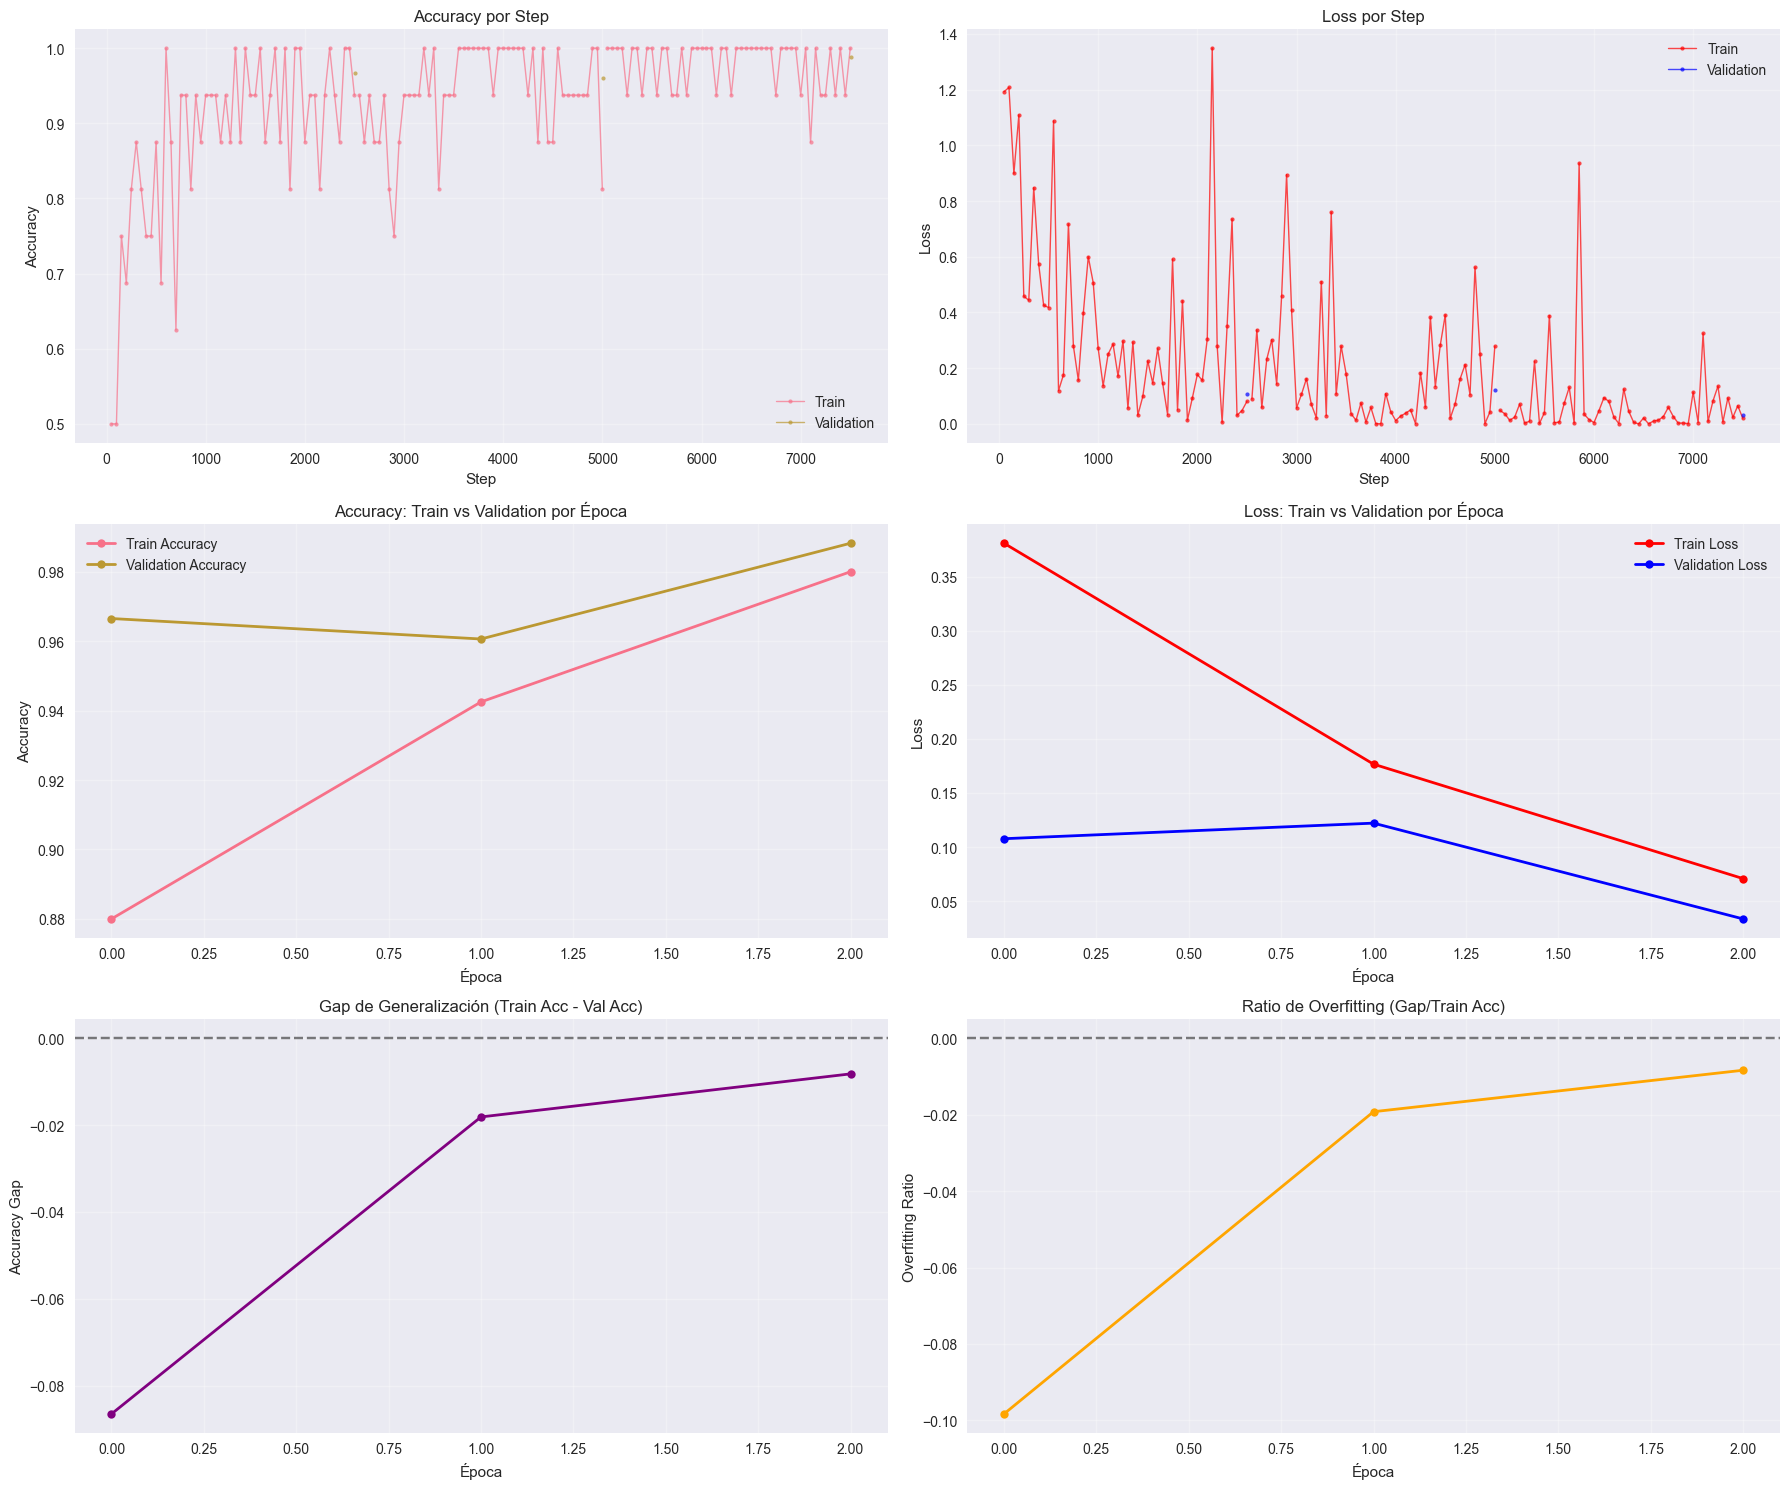

📊 ESTADÍSTICAS COMPLETAS DE ENTRENAMIENTO:
   • Train Accuracy: 0.934 ± 0.090
   • Train Loss: 0.209 ± 0.277
   • Validation Accuracy: 0.972 ± 0.015
   • Validation Loss: 0.088 ± 0.048
   • Accuracy Gap: -0.038 (train > val)
   • Best Validation Accuracy: 0.988
   • Best Train Accuracy: 1.000
   • Best Train Loss: 0.000


,epoch,step,train_acc,train_loss,val_acc,val_loss
0,0,49,0.5000,1.192150,NaN,NaN
1,0,99,0.5000,1.207897,NaN,NaN
2,0,149,0.7500,0.898927,NaN,NaN
3,0,199,0.6875,1.109111,NaN,NaN
4,0,249,0.8125,0.458481,NaN,NaN
...,...,...,...,...,...,...
148,2,7349,0.9375,0.093283,NaN,NaN
149,2,7399,1.0000,0.023509,NaN,NaN
150,2,7449,0.9375,0.065198,NaN,NaN
151,2,7499,1.0000,0.020584,NaN,NaN


In [49]:
import pandas as pd

df = pd.read_csv(r"D:\Ciencias\SIS421-022025\Laboratorios\Laboratorio 5\lightning_logs\version_0\metrics.csv", sep=",")
df.head()

plot_from_dataframe(df)
# plot_comparison_metrics(df)

In [173]:
def load_and_preprocess_image(image_path, patch_size=(16, 16), img_size=(224, 224)):
    """
    Carga y preprocesa una imagen individual para el modelo de atención
    """
    # Cargar imagen
    img = Image.open(image_path).convert("RGB")
    
    # Redimensionar
    img = img.resize(img_size)
    
    # Convertir a tensor y normalizar
    img_tensor = torch.tensor(np.array(img)).float().permute(2, 0, 1) / 255
    
    # Extraer patches (igual que en el dataset)
    C, H, W = img_tensor.shape
    hh, ww = patch_size
    
    patches = img_tensor.unfold(1, hh, hh).unfold(2, ww, ww)
    patches = patches.permute(1, 2, 0, 3, 4).contiguous()
    patches = patches.view(-1, C * hh * ww)
    
    # Añadir dimensión de batch
    patches = patches.unsqueeze(0)  # (1, num_patches, C*hh*ww)
    
    return patches, img_tensor

In [175]:
def predict_single_image(model, image_path, patch_size=(16, 16), img_size=(224, 224)):
    # Cargar y preprocesar imagen
    patches, original_img = load_and_preprocess_image(image_path, patch_size, img_size)
    
    # Mover al dispositivo del modelo
    device = next(model.parameters()).device
    patches = patches.to(device)
    
    # Predecir
    with torch.no_grad():
        model.eval()
        pred = model(patches)
        pred_class = pred.argmax(dim=1).item()
        pred_probs = F.softmax(pred, dim=1)[0]  # Probabilidades
    
    return pred_class, pred_probs, original_img, patches

In [176]:
def visualize_prediction(image_path, model, class_names=None):
    # Hacer predicción
    pred_class, pred_probs, original_img, patches = predict_single_image(model, image_path)
    
    # Obtener nombres de clases (si están disponibles)
    if class_names is None:
        class_names = [f'Class {i}' for i in range(5)]
    
    # Crear figura
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Mostrar imagen original
    axes[0].imshow(original_img.permute(1, 2, 0).numpy())
    axes[0].set_title('Imagen Original', fontsize=14)
    axes[0].axis('off')
    
    # Mostrar probabilidades
    axes[1].barh(class_names, pred_probs.cpu().numpy())
    axes[1].set_xlabel('Probabilidad', fontsize=12)
    axes[1].set_title(f'Predicción: {class_names[pred_class]}', fontsize=14)
    axes[1].set_xlim(0, 1)
    
    # Añadir valores de probabilidad
    for i, prob in enumerate(pred_probs.cpu().numpy()):
        axes[1].text(prob + 0.01, i, f'{prob:.3f}', va='center')
    
    plt.tight_layout()
    plt.show()
    
    return pred_class, pred_probs


In [177]:
def visualize_patches_from_image(image_path, model, patch_size=(16, 16)):
    """
    Visualiza todos los patches de una imagen
    """
    # Cargar imagen
    patches, original_img = load_and_preprocess_image(image_path, patch_size)
    
    # Mover al dispositivo del modelo
    device = next(model.parameters()).device
    patches = patches.to(device)
    
    # Predecir
    with torch.no_grad():
        model.eval()
        pred = model(patches)
        pred_class = pred.argmax(dim=1).item()
    
    # Parámetros
    C, hh, ww = 3, patch_size[0], patch_size[1]
    num_patches = patches.shape[1]
    grid_size = int(num_patches ** 0.5)  # 14 para 224x224 con patches 16x16
    
    # Crear figura
    fig = plt.figure(figsize=(12, 12))
    
    # Mostrar todos los patches
    for i in range(grid_size):
        for j in range(grid_size):
            patch_idx = i * grid_size + j
            patch_flat = patches[0, patch_idx]  # (C*hh*ww,)
            patch = patch_flat.view(C, hh, ww).permute(1, 2, 0).cpu().numpy()
            
            ax = plt.subplot(grid_size, grid_size, patch_idx + 1)
            ax.imshow(patch)
            ax.axis('off')
            # ax.set_title(f'{i},{j}', fontsize=6)  # Opcional: coordenadas
    
    fig.suptitle(f'Predicción: Clase {pred_class}', fontsize=16)
    plt.tight_layout()
    plt.show()

In [163]:
def load_model_complete(checkpoint_path, model_class=EnhancedAttentionModel):
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    
    if 'hyperparameters' in checkpoint:
        config = checkpoint['hyperparameters']
        print("Cargando modelo con configuración:", config)
        
        model = model_class(
            n_embd=config['n_embd'],
            seq_len=config['seq_len'],
            num_classes=config['num_classes']
        )
        
        model.load_state_dict(checkpoint['model_state_dict'])
        
    else:
        model = torch.load(checkpoint_path)
    
    model.eval()
    print("Modelo cargado exitosamente!")
    return model

## 10.- Prediccion de Desechos Solidos

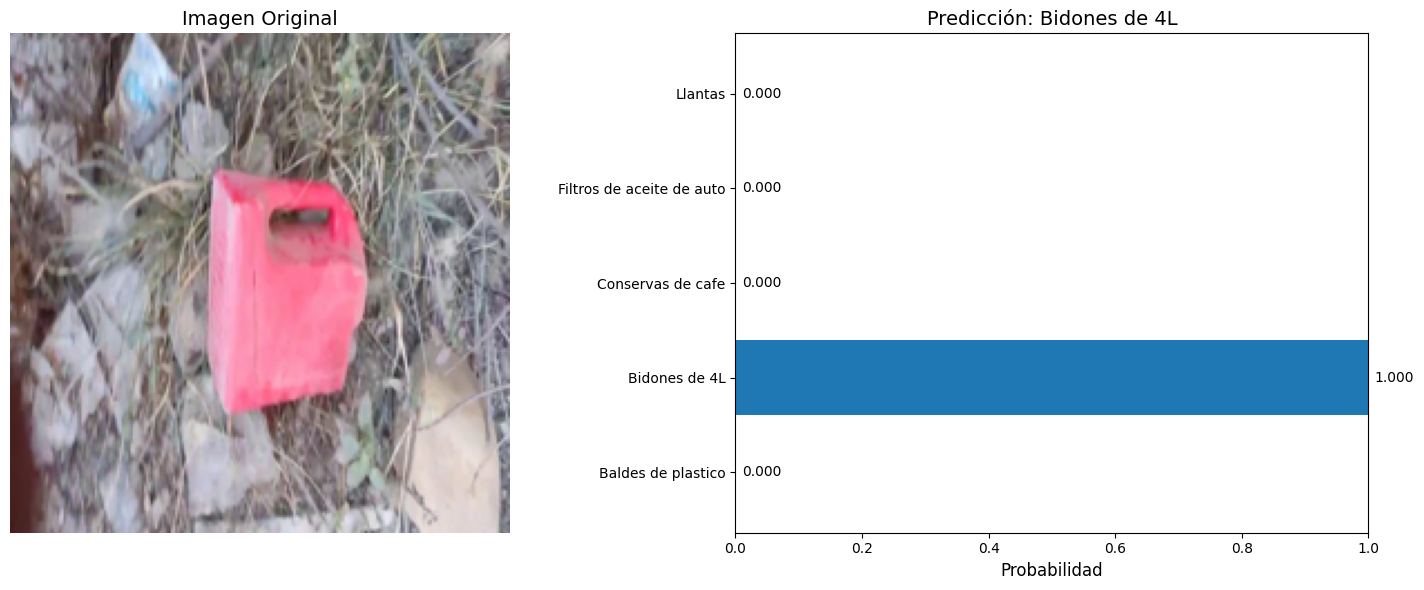

Predicted class: 1, Probabilities: tensor([1.5490e-06, 1.0000e+00, 1.0189e-08, 7.9914e-09, 5.0265e-11])


In [ ]:
image_path = r"D:\Ciencias\Dataset Residuos solidos\data\val\Bidones de 4L\4ofv9l58cdadz49u.jpg"
# loaded_model = load_model_complete(r"D:\Ciencias\SIS421-022025\Laboratorios\Laboratorio 5\lightning_logs\version_0\checkpoints\epoch=19-step=2340.ckpt")
class_names = [
    'Baldes de plastico', 
    'Bidones de 4L', 
    'Conservas de cafe', 
    'Filtros de aceite de auto', 
    'Llantas'
]
pred_class, pred_probs = visualize_prediction(image_path=image_path, model=model, class_names=class_names)
print(f'Predicted class: {pred_class}, Probabilities: {pred_probs}')

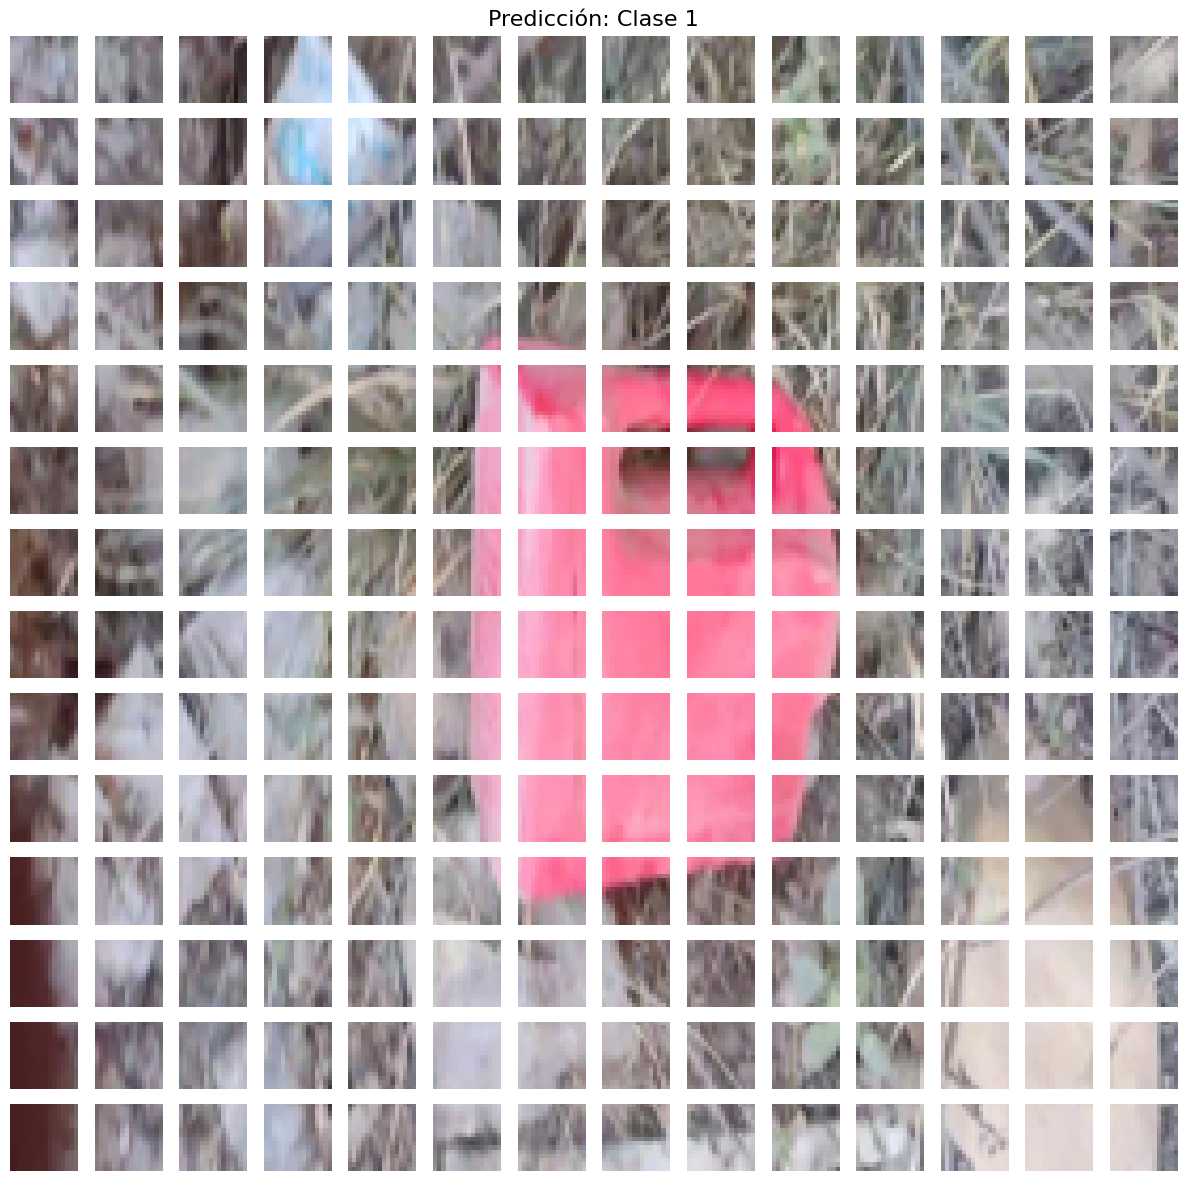

In [182]:
visualize_patches_from_image(image_path=image_path, model=model, patch_size=patch_size)

In [150]:
import torch

def save_model_with_metadata(model, trainer, config, save_path="model_with_metadata.pth"):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': trainer.optimizers[0].state_dict(),
        'hyperparameters': config,
        'epoch': trainer.current_epoch,
        'val_acc': trainer.callback_metrics.get('val_acc', 0.0),
        'val_loss': trainer.callback_metrics.get('val_loss', 0.0)
    }
    
    torch.save(checkpoint, save_path)
    print(f"Modelo con metadata guardado como: {save_path}")
    return save_path


In [162]:
# import sys
# import os

# # sys.path.append(os.path.abspath("."))
# # from functions.save_model import save_model_with_metadata

save_path = "desechos_model_1.pth"
config = {
    'patch_size': patch_size,
    'img_size': img_size,
    'n_embd': n_embd,
    'seq_len': seq_len,
    'num_classes': 5,
    'batch_size': batch_size,
    'max_epochs': max_epochs
}

metadata_path = save_model_with_metadata(model, trainer, config, save_path=save_path)

Modelo con metadata guardado como: desechos_model_1.pth


In [ ]:
loaded_model = load_model_complete(save_path)